# Датасет был взят с kaggle, а также в рамках задания был обрезан, для составления моделей.

Ссылка на сам даатсет: https://www.kaggle.com/datasets/theovall/phonereviews

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import (accuracy_score
                             , precision_score
                             , recall_score
                             , f1_score
                             , roc_auc_score)

from skopt import BayesSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pymorphy2
from pymorphy2 import MorphAnalyzer
import re

import pickle

In [2]:
df_first = pd.read_csv('reviews.csv')
df_first

,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
2,"В Apple окончательно решили не заморачиваться,...",3
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон. Пользоваться одно удовольст...,5
...,...,...
458424,"удобный, всё работает отлично, звонит, играет,...",5
458425,"прошло больше года, притензий нет, при моей на...",5
458426,мой первый аппарат на андроиде. На данный моме...,5
458427,Разбил iphone и не было желания покупать новый...,5


In [3]:
# узнаем количество пропусков
def count_missing_values(df):
    missing_values = df_first.isnull().sum()
    missing_df = pd.DataFrame(missing_values, columns=['Количество пропущеннных значений'])
    missing_df['Общее количество данных'] = len(df_first)
    missing_df['Пропущенных значений в %'] = round((missing_df['Количество пропущеннных значений'] / missing_df['Общее количество данных']) * 100, 2)
    return missing_df

# Проверяем количество пропущенных значений
missing_df = count_missing_values(df_first)
missing_df

,Количество пропущеннных значений,Общее количество данных,Пропущенных значений в %
Review,596,458429,0.13
Rating,0,458429,0.00


In [4]:
# узнаем уникальные значения.
def get_unique_values(df_first, column_name):
    unique_values = df_first[column_name].unique()
    return unique_values

# Получаем уникальные значения в столбце 'Rating'
unique_values = get_unique_values(df_first, 'Rating')
unique_values

array([5, 4, 3, 2, 1], dtype=int64)

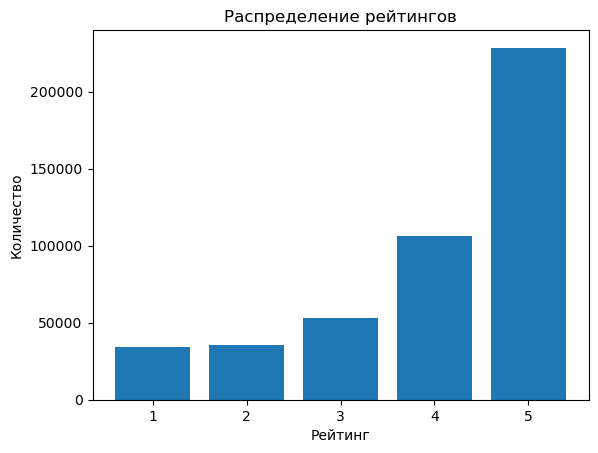

In [5]:
# Получаем количество значений для каждого рейтинга от 1 до 5
rating_counts = df_first[df_first['Rating'].between(1, 5)].groupby('Rating').size()

# Создаем диаграмму
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.title('Распределение рейтингов')
plt.show()

У нас идут отметки рейтин от 1 до 5 поэтому мы можем сделать разметку следующим образом:
1. Диапазон отметок от `1 до 2` обозначить как - **плохие отзывы**
2. Диапазон отметок `3` обозначить - как **нейтральные отзывы**
3. Диапазон отметок от `4 до 5` обозначаить как - **хорошие отзывы**

In [6]:
def classify_review(rating):
    if rating in [1, 2]:
        return 'Плохие'
    elif rating == 3:
        return 'Нейтральные'
    elif rating in [4, 5]:
        return 'Хорошие'

df_first['label'] = df_first['Rating'].apply(classify_review)

In [7]:
df_first.head()

,Review,Rating,label
0,3D Touch просто восхитительная вещь! Заряд дер...,5,Хорошие
1,"Отключается при температуре близкой к нулю, не...",4,Хорошие
2,"В Apple окончательно решили не заморачиваться,...",3,Нейтральные
3,Постарался наиболее ёмко и коротко описать все...,4,Хорошие
4,Достойный телефон. Пользоваться одно удовольст...,5,Хорошие


Столбец Rating нам больше не понадобится, можно спокойно его удалять

In [8]:
df_first = df_first.drop(['Rating'],axis=1)
df_first

,Review,label
0,3D Touch просто восхитительная вещь! Заряд дер...,Хорошие
1,"Отключается при температуре близкой к нулю, не...",Хорошие
2,"В Apple окончательно решили не заморачиваться,...",Нейтральные
3,Постарался наиболее ёмко и коротко описать все...,Хорошие
4,Достойный телефон. Пользоваться одно удовольст...,Хорошие
...,...,...
458424,"удобный, всё работает отлично, звонит, играет,...",Хорошие
458425,"прошло больше года, притензий нет, при моей на...",Хорошие
458426,мой первый аппарат на андроиде. На данный моме...,Хорошие
458427,Разбил iphone и не было желания покупать новый...,Хорошие


Хорошие        335085
Плохие          70253
Нейтральные     53091
Name: label, dtype: int64


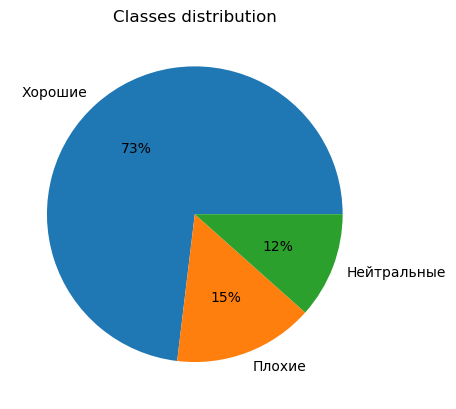

In [9]:
# смотрим на распределение наших классов
classes = pd.value_counts(df_first["label"])

print(classes)

classes.plot(kind = 'pie',  autopct='%0.f%%') 

plt.title("Classes distribution")

plt.ylabel('')

plt.show()

В идеале можно было бы удалить нейтральные отзывы, и поработать только с двумя классами: "Хорошие" и "Плохие" отзывы, но так как задача учебная и к тому же у нас нет данных для валидации, то попробуем поработать с тремя классами.

Датасет получается слишком большой и исходя из ограниченности вычислительных ресурсов, мы вынуждены его сократить до 50 000 строк для дальнейшего обучения. В целях соблюдения схожести данных изначальных мы сохранили процентовку хороших, плохих и нейтральных данных как была изначальна, а также оставили возможность попадания пропущенных значений засчет параметра random_state

In [10]:
# Берем случайные подмножества для каждой метки
df_good = df_first[df_first['label'] == 'Хорошие'].sample(n=int(50000*0.73), random_state=1)
df_neutral = df_first[df_first['label'] == 'Нейтральные'].sample(n=int(50000*0.12), random_state=1)
df_bad = df_first[df_first['label'] == 'Плохие'].sample(n=int(50000*0.15), random_state=1)

# Объединяем все подмножества в один DataFrame
df_sample = pd.concat([df_good, df_neutral, df_bad])

# Перемешиваем строки, чтобы обеспечить случайность порядка
df_sample = df_sample.sample(frac=1, random_state=1).reset_index(drop=True)
df_sample

,Review,label
0,Лучшее творение от самсунг,Хорошие
1,"В целом за такую цену отличный смартфон, взял ...",Хорошие
2,До этого пользовался Sony xperia Z3 compact ок...,Хорошие
3,Многие жалуются что телефон постоянно сам откл...,Хорошие
4,Отличный телефон. Все сделано очень круто. Кам...,Хорошие
...,...,...
49995,"Покупал ребенку первый телефон, выбирал не дор...",Плохие
49996,Приобрёл в Связной данный девайс но через 10 д...,Хорошие
49997,И вот уже прошло 9 месяцев-за это время все со...,Хорошие
49998,хороший телефон для звонков для остального мож...,Хорошие


In [11]:
# сохраняем наш датасет
df_sample.to_csv('sample.csv', index=False)

In [12]:
# # можно просто прочитать готовый датасет (раскоментить если нужно использовать повторно)
# df_sample = pd.read_csv('sample.csv')

Хорошие        36500
Плохие          7500
Нейтральные     6000
Name: label, dtype: int64


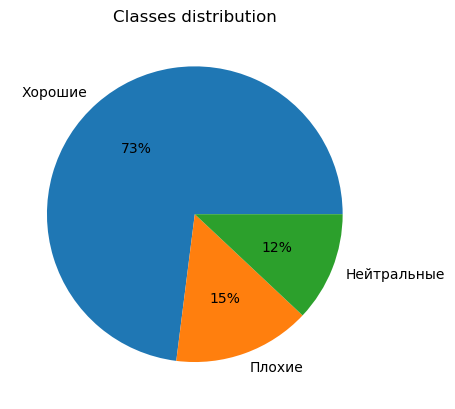

In [13]:
# смотрим на распределение наших классов
classes = pd.value_counts(df_sample["label"])

print(classes)

classes.plot(kind = 'pie',  autopct='%0.f%%') 

plt.title("Classes distribution")

plt.ylabel('')

plt.show()

# Предобработка данных

In [14]:
df = df_sample.copy()

Пропущенные комментарии восстановить мы, к сожалению, никак не сможем. В реальных условиях можно воспользоваться экспертной оценкой, а при иных обстоятельствах пропуски можно заменить, например, на среднее или медианное значение, но в данном случае, т.к. у нас незначительное количество пропусков в датасете, нами было принято решение удалить строки с пропущенными комментариями.

In [15]:
# Удаление строк с пропущенными значениями
df = df.dropna(subset=['Review'])

In [16]:
# nltk.download('punkt')
# nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text_with_progress(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)
    words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
    return " ".join(words)

# примените функцию предобработки ко всем обзорам с отслеживанием прогресса
tqdm.pandas()
df['Review'] = df['Review'].progress_apply(preprocess_text_with_progress)

100%|███████████████████████████████████████████████████████████████████████████| 49939/49939 [02:23<00:00, 348.10it/s]


### Векторизация текстов

In [17]:
# создаем векторизатор
vectorizer = TfidfVectorizer()

# обучаем векторизатор и преобразуем наши данные
X = vectorizer.fit_transform(df['Review'])

# Мы также преобразуем наши метки в численный формат
label_mapping = {"Хорошие": 0, "Нейтральные": 1, "Плохие": 2}
y = df['label'].replace(label_mapping)

In [18]:
# размер матриц
display(X.shape)

(49939, 92809)

In [19]:
# разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей

In [20]:
# Получаем метрики
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 score": f1}

In [21]:
# Узнаем время обучения моделей
def train_and_time_model(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = round(end_time - start_time, 4)
    return model, training_time

## Создаем модель KNN

In [22]:
# # Создаем и обучаем модель KNN
# knn_model = KNeighborsClassifier()
# knn_model, knn_training_time = train_and_time_model(knn_model, X_train, y_train)

# # Получаем метрики модели
# knn_metrics = get_metrics(knn_model, X_test, y_test)

# print(f"Время обучения модели KNN: {knn_training_time} секунд")

## Создаем модель Decision Tree

In [23]:
# # Создаем и обучаем модель Decision Tree
# decision_tree_model = DecisionTreeClassifier(random_state=42)
# decision_tree_model, decision_tree_training_time = train_and_time_model(decision_tree_model, X_train, y_train)

# # Получаем метрики модели
# decision_tree_metrics = get_metrics(decision_tree_model, X_test, y_test)

# print(f"Время обучения модели DecisionTree: {decision_tree_training_time} секунд")

# Создаем модель на основе Gradient Boosting

In [24]:
# # Создаем и обучаем модель Decision Gradient Boosting Classifier
# boosting_model = GradientBoostingClassifier(random_state=42)
# boosting_model, boosting_training_time = train_and_time_model(boosting_model, X_train, y_train)

# # Получаем метрики модели
# boosting_metrics = get_metrics(boosting_model, X_test, y_test)

# print(f"Время обучения модели Gradient Boosting: {boosting_training_time} секунд")

In [25]:
# # Создадим датафрейм, содержащий все метрики
# all_metrics = pd.DataFrame([knn_metrics, decision_tree_metrics, boosting_metrics],
#                           index=["KNN", "Decision Tree", "Gradient Boosting"])
# # сортируем по accuracy
# all_metrics.sort_values(by="Accuracy", ascending=False)

#### Заметка: Также можно создать pipline, включив сразу все модели.

In [27]:
# получаем метрики для каждой модели
def get_metrics(model, X_train, y_train, X_test, y_test):
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, test_y_pred)
    precision = precision_score(y_test, test_y_pred, average='weighted')
    recall = recall_score(y_test, test_y_pred, average='weighted')
    f1 = f1_score(y_test, test_y_pred, average='weighted')
    
    return {"Accuracy": test_accuracy, "Precision": precision, "Recall": recall, "F1 score": f1}

# создаем pipline для обучения моделей
def train_model(model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([('model', model)])
    
    # Обучаем модель и замеряем время обучения
    model, training_time = train_and_time_model(pipeline, X_train, y_train)

    # Получаем метрики модели
    metrics = get_metrics(model, X_train, y_train, X_test, y_test)
    # Добавляем время обучения в метрики
    metrics["Training Time"] = training_time

    return model, metrics

# Обучим каждую модель
knn_model, knn_metrics = train_model(KNeighborsClassifier(), X_train, y_train, X_test, y_test)
decision_tree_model, decision_tree_metrics = train_model(DecisionTreeClassifier(random_state=42), X_train, y_train, X_test, y_test)
boosting_model, boosting_metrics = train_model(GradientBoostingClassifier(random_state=42), X_train, y_train, X_test, y_test)

# создаем DataFrame c метриками
results_df = pd.DataFrame([knn_metrics, decision_tree_metrics, boosting_metrics],
                          index=["KNN", "Decision Tree", "Boosting"])

# сортируем по accuracy
results_df.sort_values(by="Accuracy", ascending=False)

,Accuracy,Precision,Recall,F1 score,Training Time
Boosting,0.758210,0.711903,0.758210,0.679540,906.5026
KNN,0.733680,0.690745,0.733680,0.630652,0.0060
Decision Tree,0.718662,0.701776,0.718662,0.709389,36.6046


# Подбор гиперпараметров

Подбирать гиперпараметры будем при помощи модуля GridSearchCV из scikit-learn

In [ ]:
# # Если без pipline то раскоменчиваем это
# # Определение параметров для KNN
# knn_params = {'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance']}
# knn_gs = GridSearchCV(knn_model, param_grid=knn_params, cv=5)
# knn_gs.fit(X_train, y_train)

# # Определение параметров для Decision Tree
# tree_params = {'model__max_depth': [None, 2, 4, 6, 8, 10], 'model__criterion': ['gini', 'entropy']}
# tree_gs = GridSearchCV(decision_tree_model, param_grid=tree_params, cv=5)
# tree_gs.fit(X_train, y_train)

# # Определение параметров для Gradient Boosting
# boost_params = {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 1]}
# boost_gs = GridSearchCV(boosting_model, param_grid=boost_params, cv=5)
# boost_gs.fit(X_train, y_train)

# # Получаем наилучшие параметры
# print("Best parameters for KNN: ", knn_gs.best_params_)
# print("Best parameters for Decision Tree: ", tree_gs.best_params_)
# print("Best parameters for Gradient Boosting: ", boost_gs.best_params_)

In [28]:
pipeline = Pipeline([('model', KNeighborsClassifier())])

# Определение параметров для KNN
knn_params = {'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance']}
knn_gs = GridSearchCV(pipeline, param_grid=knn_params, cv=5)
knn_gs.fit(X_train, y_train)

knn_best_params = knn_gs.best_params_
# Получаем наилучшие параметры
print("Best parameters for KNN: ", knn_best_params)

Best parameters for KNN:  {'model__n_neighbors': 5, 'model__weights': 'distance'}


In [29]:
pipeline_tree = Pipeline([('model', DecisionTreeClassifier())])
# Определение параметров для Decision Tree
tree_params = {'model__max_depth': [None, 2, 4, 6, 8, 10], 'model__criterion': ['gini', 'entropy']}
tree_gs = GridSearchCV(pipeline_tree, param_grid=tree_params, cv=5)
tree_gs.fit(X_train, y_train)

tree_best_params = tree_gs.best_params_
# Получаем наилучшие параметры
print("Best parameters for Decision Tree: ", tree_best_params)

Best parameters for Decision Tree:  {'model__criterion': 'gini', 'model__max_depth': 10}


In [ ]:
# pipeline_boost = Pipeline([('model', GradientBoostingClassifier())])
# # Определение параметров для Gradient Boosting
# boost_params = {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 1]}
# boost_gs = GridSearchCV(pipeline_boost, param_grid=boost_params, cv=5)
# boost_gs.fit(X_train, y_train)

# # Получаем наилучшие параметры
# print("Best parameters for Gradient Boosting: ", boost_gs.best_params_)

In [31]:
# Подставляем подобранные параметры прямо в определения моделей
knn_model, knn_metrics = train_model(KNeighborsClassifier(n_neighbors=knn_best_params['model__n_neighbors'],
                                                          weights=knn_best_params['model__weights']), 
                                     X_train, y_train, X_test, y_test)

decision_tree_model, decision_tree_metrics = train_model(DecisionTreeClassifier(max_depth=tree_best_params['model__max_depth'],
                                                                                criterion=tree_best_params['model__criterion'],
                                                                                random_state=42),
                                                        X_train, y_train, X_test, y_test)

# boosting_model, boosting_metrics = train_model(GradientBoostingClassifier(n_estimators=boost_best_params['model__n_estimators'],
#                                                                           learning_rate=boost_best_params['model__learning_rate'],
#                                                                           random_state=42), 
#                                                X_train, y_train, X_test, y_test)

# Собираем все метрики в одну таблицу
results_df_best = pd.DataFrame([knn_metrics, decision_tree_metrics], # boosting_metrics
                               index=["KNN_best", "Decision Tree_best"]) # "Boosting_best" (добавить в скобки, если будет подбор гиперпараметров для бустинга)

# Сортируем по Test Accuracy
results_df_best.sort_values(by="Accuracy", ascending=False)

,Accuracy,Precision,Recall,F1 score,Training Time
KNN_best,0.759211,0.760235,0.759211,0.689121,0.0080
Decision Tree_best,0.742791,0.657214,0.742791,0.666857,4.2827


Мы видим, что после подбора гиперпараметров, метрика Accuracy улучшилась у моделей KNN и Decision Tree. Можем предположить, что данная метрика улучшится и у модели основанной на Gradient Boosting

# Визуализация

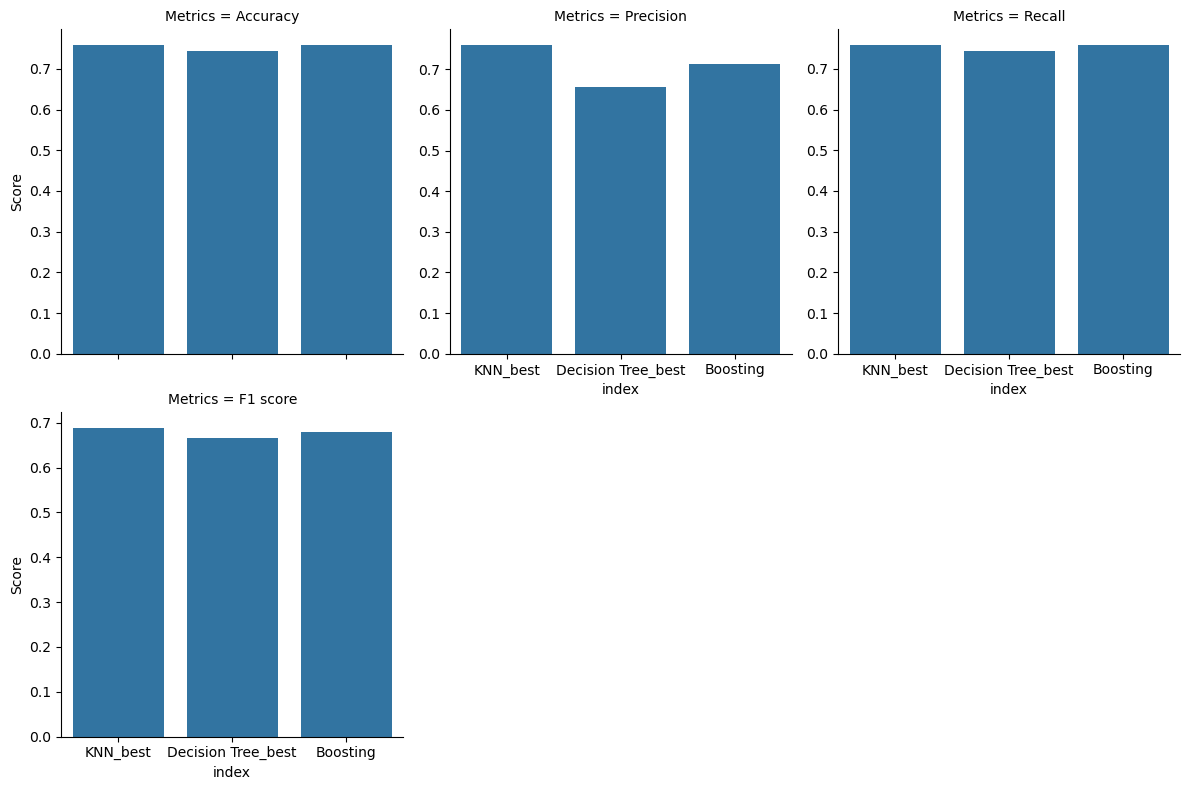

In [32]:
# # Удаление столбца Training Time
# results_df_best = results_df_best.drop(['Training Time'], axis=1)

# Извлекаем строку с метриками для модели Boosting
boosting_metrics = results_df.loc[['Boosting']]

# Объединяем метрики начальные и после оптимизации в один DataFrame
results_combined = pd.concat([results_df_best, boosting_metrics])

# Удаление столбца Training Time
results_combined = results_combined.drop(['Training Time'], axis=1)

# Преобразование данных для визуализации
results_melt = pd.melt(results_combined.reset_index(), id_vars='index', var_name='Metrics', value_name='Score')

# Создание сетки графиков
g = sns.FacetGrid(results_melt, col="Metrics", height=4, aspect=1, col_wrap=3, sharey=False)

# Построение диаграмм
g.map(sns.barplot, "index", "Score", order=results_combined.index)

# Отображение графиков
plt.show()

In [33]:
# Сохраняем модели
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)
    
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(decision_tree_model, file)
    
with open('boosting_model.pkl', 'wb') as file:
    pickle.dump(boosting_model, file)

# Оптимизация гиперпараметров с использованием байесовской оптимизации

In [34]:
# Определение диапазона параметров для KNN
knn_param_space = {'n_neighbors': (1, 10), 'weights': ['uniform', 'distance']}

knn_bayes_search = BayesSearchCV(KNeighborsClassifier(), knn_param_space, n_iter=32, cv=5, n_jobs=-1)
knn_bayes_search.fit(X_train, y_train)

print("Best parameters for KNN: ", knn_bayes_search.best_params_)

# Определение диапазона параметров для DecisionTreeClassifier
tree_param_space = {'criterion': ['gini', 'entropy'], 'max_depth': (1, 50)}

tree_bayes_search = BayesSearchCV(DecisionTreeClassifier(random_state=42), tree_param_space, n_iter=32, cv=5, n_jobs=-1)
tree_bayes_search.fit(X_train, y_train)

print("Best parameters for Decision Tree: ", tree_bayes_search.best_params_)

# # Определение диапазона параметров для GradientBoostingClassifier
# boost_param_space = {'n_estimators': (10, 100), 'learning_rate': (0.01, 1.0, 'log-uniform')}

# boost_bayes_search = BayesSearchCV(GradientBoostingClassifier(random_state=42), boost_param_space, n_iter=32, cv=5, n_jobs=-1)
# boost_bayes_search.fit(X_train, y_train)

# print("Best parameters for Gradient Boosting: ", boost_bayes_search.best_params_)

C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\

Best parameters for KNN:  OrderedDict([('n_neighbors', 7), ('weights', 'distance')])


C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nekon\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameters for Decision Tree:  OrderedDict([('criterion', 'gini'), ('max_depth', 16)])


In [36]:
# Создание и обучение модели KNN с наилучшими параметрами
best_knn = KNeighborsClassifier(**knn_bayes_search.best_params_)
best_knn.fit(X_train, y_train)
knn_metrics = get_metrics(best_knn, X_train, y_train, X_test, y_test)

# Создание и обучение модели Decision Tree с наилучшими параметрами
best_tree = DecisionTreeClassifier(random_state=42, **tree_bayes_search.best_params_)
best_tree.fit(X_train, y_train)
tree_metrics = get_metrics(best_tree, X_train, y_train, X_test, y_test)

# # Создание и обучение модели Gradient Boosting с наилучшими параметрами
# best_boost = GradientBoostingClassifier(random_state=42, **boost_bayes_search.best_params_)
# best_boost.fit(X_train, y_train)
# boost_metrics = get_metrics(best_boost, X_train, y_train, X_test, y_test)

# создаем DataFrame c метриками
tuned_results_df = pd.DataFrame([knn_metrics, tree_metrics], #boost_metrics
                          index=["Tuned KNN", "Tuned Decision Tree"]) #"Tuned Boosting" (добавить в скобки, если будет подбор гиперпараметров для бустинга)

# сортируем по accuracy
tuned_results_df.sort_values(by="Accuracy", ascending=False)

,Accuracy,Precision,Recall,F1 score
Tuned KNN,0.758110,0.768920,0.758110,0.684758
Tuned Decision Tree,0.749299,0.678699,0.749299,0.683859


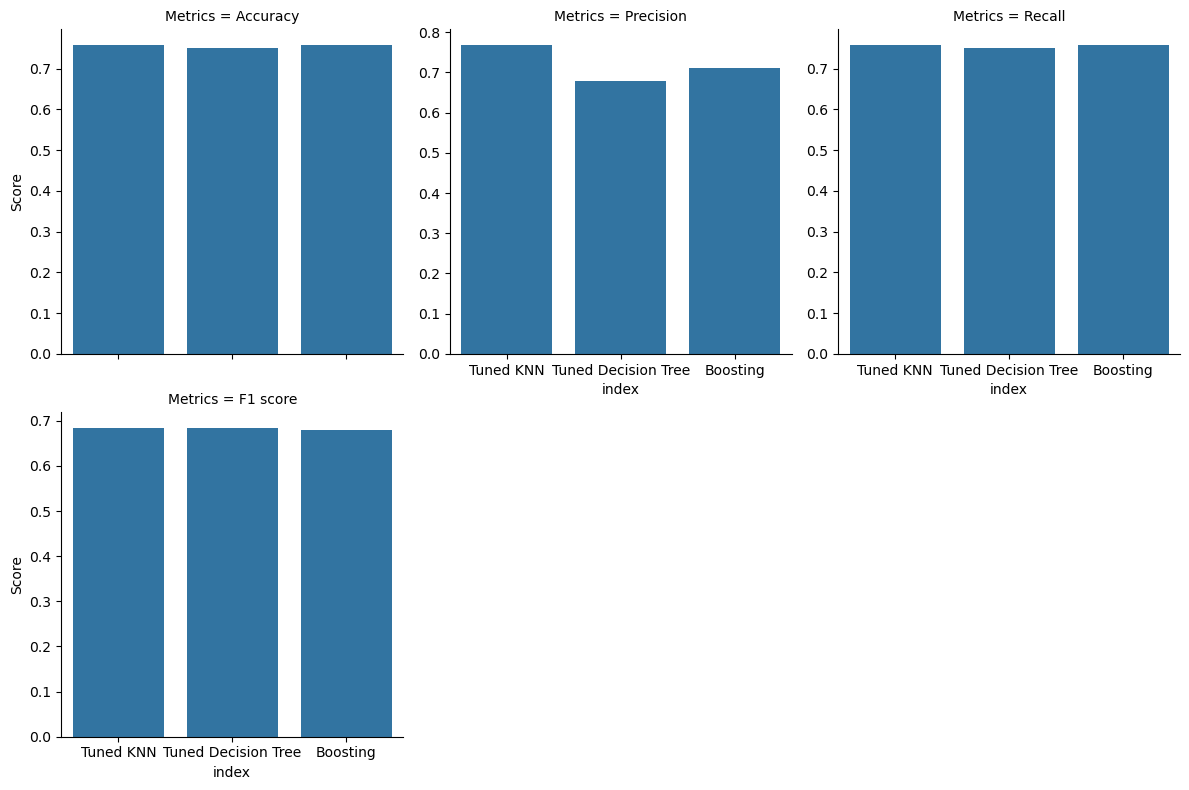

In [38]:
# Извлекаем строку с метриками для модели Boosting
boosting_metrics = results_df.loc[['Boosting']]

# Объединяем метрики начальные и после оптимизации в один DataFrame
results_combined = pd.concat([tuned_results_df, boosting_metrics])

# Удаление столбца Training Time
results_combined = results_combined.drop(['Training Time'], axis=1)

# Преобразование данных для визуализации
results_melt = pd.melt(results_combined.reset_index(), id_vars='index', var_name='Metrics', value_name='Score')

# Создание сетки графиков
g = sns.FacetGrid(results_melt, col="Metrics", height=4, aspect=1, col_wrap=3, sharey=False)

# Построение диаграмм
g.map(sns.barplot, "index", "Score", order=results_combined.index)

# Отображение графиков
plt.show()

Можно сделать вывод, что подбор гиперпараметров при помощи GridSearchCV и BayesSearchCV для данных моделей отличается не слишком сильно, поэтому особой разницы в том какой из этих методов применять - нет.

# Проверяем нашу модель

In [37]:
# Определение функции для предобработки текста
morph = MorphAnalyzer()

def preprocess_text(text, morph):
    # Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов
    words = text.split()
    words = [word for word in words if word not in stopwords.words('russian')]
    # Лемматизация
    words = [morph.parse(word)[0].normal_form for word in words]
    # Объединение слов обратно в текст
    text = " ".join(words)
    return text

# Определение функции для предсказания категории
def predict_category(text, model, vectorizer, morph):
    text = preprocess_text(text, morph)
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)
    return prediction

# Создание списка текстов
texts = [
    "Купил эту модель и остался очень доволен. Замечательный телефон",
    "Ужасный телефон. Не рекомендую", 
    "В восторге от телефона apple, наконец-то осуществил свою мечту",
    "Ничего особенного в этом телефоне нет, средний вариант"
]

# Создаем словарь для преобразования предсказаний
categories = {0: "Хороший", 1: "Нейтральный", 2: "Плохой"}

# Предсказание категории для каждого текста
for text in texts:
    knn_prediction = predict_category(text, knn_model, vectorizer, morph)
    decision_tree_prediction = predict_category(text, decision_tree_model, vectorizer, morph)
    boosting_prediction = predict_category(text, boosting_model, vectorizer, morph)
    print(f'Text: "{text}"')
    print("KNN prediction: ", categories[knn_prediction[0]])
    print("Decision Tree prediction: ", categories[decision_tree_prediction[0]])
    print("Boosting prediction: ", categories[boosting_prediction[0]])
    print('---')

Text: "Купил эту модель и остался очень доволен. Замечательный телефон"
KNN prediction:  Хороший
Decision Tree prediction:  Хороший
Boosting prediction:  Хороший
---
Text: "Ужасный телефон. Не рекомендую"
KNN prediction:  Плохой
Decision Tree prediction:  Плохой
Boosting prediction:  Плохой
---
Text: "В восторге от телефона apple, наконец-то осуществил свою мечту"
KNN prediction:  Хороший
Decision Tree prediction:  Хороший
Boosting prediction:  Хороший
---
Text: "Ничего особенного в этом телефоне нет, средний вариант"
KNN prediction:  Плохой
Decision Tree prediction:  Хороший
Boosting prediction:  Хороший
---


Основным выводом является то, что Наши модели весьма точно предсказывают метки классов 0 и 2 ("Хороший" и "Плохой" отзывы) и плохо справляется с меткой класса 1 "Нейтральный". В самом начале мы отмечали, что целесообразней было бы разделить наши отзывы бинарно на "Хорошие" и "Плохие отзывы", так предсказания были бы более корректными, но в рамках учебной задачи мы решили поэксперементировать и посмотреть к чему это приведет.